# CREDIT CARD DEFAULT RISK CLASSIFICATION MODELS - MODELOS DE CLASSIFICACION PARA RIESGO CREDITICIO

In [14]:
#Importacion de librerias 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import cv
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from sklearn import metrics

In [4]:
#importacion del dataset

df = pd.read_csv('../Data/credit_risk_dataset.csv')
df

,customer_id,name,age,gender,owns_car,owns_house,no_of_children,net_yearly_income,no_of_days_employed,occupation_type,total_family_members,migrant_worker,yearly_debt_payments,credit_limit,credit_limit_used(%),credit_score,prev_defaults,default_in_last_6months,credit_card_default
0,CST_115179,ita Bose,46,F,N,Y,0.0,107934.04,612.0,Unknown,1.0,1.0,33070.28,18690.93,73,544.0,2,1,1
1,CST_121920,Alper Jonathan,29,M,N,Y,0.0,109862.62,2771.0,Laborers,2.0,0.0,15329.53,37745.19,52,857.0,0,0,0
2,CST_109330,Umesh Desai,37,M,N,Y,0.0,230153.17,204.0,Laborers,2.0,0.0,48416.60,41598.36,43,650.0,0,0,0
3,CST_128288,Rie,39,F,N,Y,0.0,122325.82,11941.0,Core staff,2.0,0.0,22574.36,32627.76,20,754.0,0,0,0
4,CST_151355,McCool,46,M,Y,Y,0.0,387286.00,1459.0,Core staff,1.0,0.0,38282.95,52950.64,75,927.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36886,CST_130421,Doris,55,F,N,N,2.0,96207.57,117.0,Unknown,4.0,0.0,11229.54,29663.83,82,907.0,0,0,0
36887,CST_136670,Luciana,31,F,N,Y,0.0,383476.74,966.0,Accountants,2.0,1.0,43369.91,139947.16,32,679.0,0,0,0
36888,CST_145435,Jessica,27,F,N,Y,0.0,260052.18,1420.0,Core staff,2.0,0.0,22707.51,83961.83,46,727.0,0,0,0
36889,CST_130913,Tessa,32,M,Y,N,0.0,157363.04,2457.0,Laborers,2.0,0.0,20150.10,25538.72,92,805.0,0,0,0


In [5]:
#Eliminacion de variables no necesarias
df = df.drop(['customer_id', 'name'], axis=1)

# Preprocesamiento de los datos

In [7]:
#Usaremos label encoder para convertir las variables categoricas en numericas
label_encoder = LabelEncoder()

#Seleccionamos las variables categoricas
cat_cols = df.select_dtypes(include=['object']).columns

#Aplicamos label encoder a las variables categoricas
for col in cat_cols:
    df[col] = label_encoder.fit_transform(df[col])

#Verificamos que se hayan convertido las variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36891 entries, 0 to 36890
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      36891 non-null  int64  
 1   gender                   36891 non-null  int64  
 2   owns_car                 36891 non-null  int64  
 3   owns_house               36891 non-null  int64  
 4   no_of_children           36891 non-null  float64
 5   net_yearly_income        36891 non-null  float64
 6   no_of_days_employed      36891 non-null  float64
 7   occupation_type          36891 non-null  int64  
 8   total_family_members     36891 non-null  float64
 9   migrant_worker           36891 non-null  float64
 10  yearly_debt_payments     36891 non-null  float64
 11  credit_limit             36891 non-null  float64
 12  credit_limit_used(%)     36891 non-null  int64  
 13  credit_score             36891 non-null  float64
 14  prev_defaults         

In [8]:
#utilizamos train_test_split para dividir el dataset en entrenamiento y prueba
x = df.drop('credit_card_default', axis=1)
y = df['credit_card_default']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y ,random_state=42)

print('Dataset de entrenamiento: ', x_train.shape, y_train.shape)
print('Dataset de prueba: ', x_test.shape, y_test.shape)

Dataset de entrenamiento:  (25823, 16) (25823,)
Dataset de prueba:  (11068, 16) (11068,)


In [10]:
#Utilizamos standarscaler para escalar las variables numericas
scaler = StandardScaler()

#Seleccionamos las variables numericas
cols = x_train.columns
x_train[cols] = scaler.fit_transform(x_train[cols])
x_test[cols] = scaler.transform(x_test[cols])

In [11]:
x_train.head()

,age,gender,owns_car,owns_house,no_of_children,net_yearly_income,no_of_days_employed,occupation_type,total_family_members,migrant_worker,yearly_debt_payments,credit_limit,credit_limit_used(%),credit_score,prev_defaults,default_in_last_6months
6591,-0.942964,1.300823,-0.753831,0.685606,-0.647850,0.333013,-0.130351,1.252495,-0.266685,-0.528564,0.064738,-0.406860,1.514194,1.249545,-0.238337,-0.239513
23947,1.468939,1.300823,1.326556,-1.458563,0.669324,0.106005,-0.058275,-0.261336,0.794262,-0.528564,2.883371,0.345660,0.460564,0.150736,-0.238337,-0.239513
1916,1.364074,-0.768744,1.326556,0.685606,-0.647850,1.997007,-0.129456,1.441724,-1.327631,-0.528564,-1.129369,1.217510,-1.034911,1.239646,-0.238337,-0.239513
25659,1.573804,-0.768744,-0.753831,0.685606,-0.647850,0.121834,3.023096,-0.261336,-0.266685,-0.528564,-0.955173,-0.446237,-0.796995,1.299041,-0.238337,-0.239513
11179,0.944612,1.300823,1.326556,0.685606,0.669324,0.621154,-0.020222,-0.261336,0.794262,-0.528564,0.051207,1.715338,-1.340804,0.061644,-0.238337,-0.239513


Teniendo en cuenta que nuestro Dataset presenta un evidente desbalance de clases, utilizaremos el metodo SMOTE para equilibrar el entrenamiento del dataset y contrarrestar el efecto que podria tener en el modelo.

In [12]:
#Smote para balancear las clases
smote = SMOTE(random_state=42)
x_train, y_train = smote.fit_resample(x_train, y_train)

print('Dataset de entrenamiento balanceado: ', x_train.shape, y_train.shape)
print('Dataset de prueba balanceado: ', x_test.shape, y_test.shape)

Dataset de entrenamiento balanceado:  (47122, 16) (47122,)
Dataset de prueba balanceado:  (11068, 16) (11068,)


# Modelo #1 XGBOOST 

In [ ]:
#Inicializamos el modelo
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    device= 'cuda',
    random_state=42
)
#Definimos los hiperparametros para el metodo de RandomizedSearchCV
params = {
    'n_estimators': [100, 150],
    'max_depth': [5, 10],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 0.9],
    'min_child_weight': [1, 3]
}

#Definimos Kfold Estraficada para validacion cruzada
str_kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

#definimos metricas de evaluacion
scoring = {
    'accuracy': metrics.make_scorer(metrics.accuracy_score),
    'precision': metrics.make_scorer(metrics.precision_score, average='binary'),
    'recall': metrics.make_scorer(metrics.recall_score, average='binary'),
    'f1': metrics.make_scorer(metrics.f1_score, average='binary'),
    'roc_auc': 'roc_auc'
}    

#Definimos RandomizedSearchCV
r_search_xgb = RandomizedSearchCV( 
    estimator=xgb_model, 
    param_distributions=params, 
    scoring=scoring,
    refit='recall', 
    n_iter=20,
    cv= str_kf,
    verbose=3,
    n_jobs=-1
)

#Entrenamos el modelo
r_search_xgb.fit(x_train, y_train)

#Mejores parametros
print('Mejores parametros: ', r_search_xgb.best_params_)
print('Mejor Score: ', r_search_xgb.best_score_)
print('Mejor Modelo: ', r_search_xgb.best_estimator_)

#Evaluando el mejor modelo
mejor_modelo = r_search_xgb.best_estimator_
y_pred = mejor_modelo.predict(x_test)

#Reporte de clasificacion
print('Reporte de clasificacion: ')
print(classification_report(y_test, y_pred))

#Matriz de confusion
print('Matriz de confusion: ')
confusion_matrix(y_test, y_pred)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Mejores parametros:  {'subsample': 0.9, 'n_estimators': 150, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.01}
Mejor Score:  0.9982173985477333
Mejor Modelo:  XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=150,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)
Reporte de c

array([[9605,  494],
       [  16,  953]])

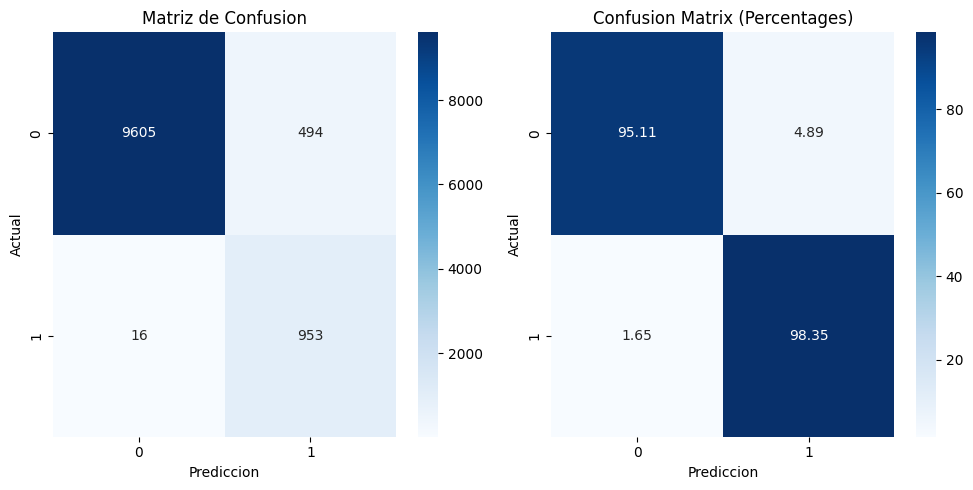

In [31]:
# Confusion matrix in normal counts
conf_matrix = confusion_matrix(y_test, y_pred)

# Confusion matrix in percentages
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Plotting the confusion matrix in counts
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusion')
plt.xlabel('Prediccion')
plt.ylabel('Actual')

# Plotting the confusion matrix in percentages
plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_percent, annot=True, fmt='.2f', cmap='Blues')
plt.title('Confusion Matrix (Percentages)')
plt.xlabel('Prediccion')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

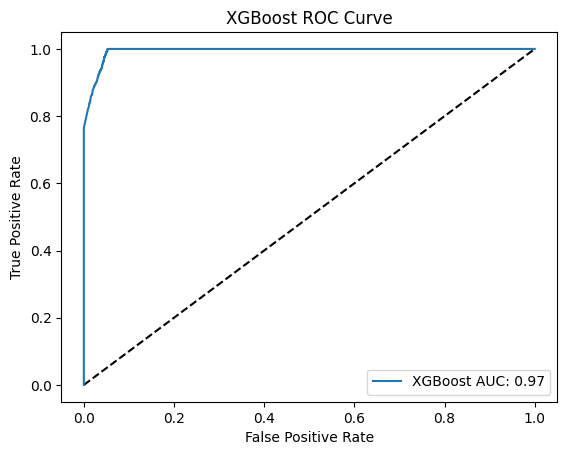

In [36]:
#curva roc
y_pred_prob = mejor_modelo.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label=f'XGBoost AUC: {roc_auc:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC Curve')
plt.legend()